In [52]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn import model_selection
from sklearn.svm import SVR
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(24,16)})

import matplotlib.pyplot as plt

In [53]:
ames_data_path = './Cleaned_AmesHousing.csv'
ames_data = pd.read_csv(ames_data_path)
ames_data


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.000000,31770,Pave,-1.0,IR1,Lvl,AllPub,Corner,Gtl,17,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,4.0,639.0,1.0,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,8,2,4.0,Attchd,1960.0,3.0,2.0,528.0,3.0,3.0,1,210,62,0,0,0,0,-1.0,-1.0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.000000,11622,Pave,-1.0,Reg,Lvl,AllPub,Inside,Gtl,17,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,3.0,468.0,2.0,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,8,0,-1.0,Attchd,1961.0,1.0,1.0,730.0,3.0,3.0,2,140,0,0,0,120,0,-1.0,3.0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.000000,14267,Pave,-1.0,IR1,Lvl,AllPub,Corner,Gtl,17,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,5.0,923.0,1.0,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,8,0,-1.0,Attchd,1958.0,1.0,1.0,312.0,3.0,3.0,2,393,36,0,0,0,0,-1.0,-1.0,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.000000,11160,Pave,-1.0,Reg,Lvl,AllPub,Corner,Gtl,17,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,5.0,1065.0,1.0,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,8,2,3.0,Attchd,1968.0,3.0,2.0,522.0,3.0,3.0,2,0,0,0,0,0,0,-1.0,-1.0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.000000,13830,Pave,-1.0,IR1,Lvl,AllPub,Inside,Gtl,10,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,6.0,791.0,1.0,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,8,1,3.0,Attchd,1997.0,3.0,2.0,482.0,3.0,3.0,2,212,34,0,0,0,0,-1.0,3.0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.000000,7937,Pave,-1.0,IR1,Lvl,AllPub,CulDSac,Gtl,16,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,6.0,819.0,1.0,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,8,0,-1.0,Detchd,1984.0,1.0,2.0,588.0,3.0,3.0,2,120,0,0,0,0,0,-1.0,4.0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,70.911185,8885,Pave,-1.0,IR1,Low,AllPub,Inside,Mod,16,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,4.0,301.0,5.0,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,8,0,-1.0,Attchd,1983.0,1.0,2.0,484.0,3.0,3.0,2,164,0,0,0,0,0,-1.0,3.0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.000000,10441,Pave,-1.0,Reg,Lvl,AllPub,Inside,Gtl,16,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,6.0,337.0,1.0,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,8,0,-1.0,None,0.0,-1.0,0.0,0.0,0.0,0.0,2

# Feature Engineering

In [54]:
#Combine Number of Bathrooms
ames_data['Total Bath']= ames_data['Bsmt Full Bath']+0.5*ames_data['Bsmt Half Bath']+ames_data['Full Bath']+0.5*ames_data['Half Bath']
ames_data.drop(columns=['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath'],inplace=True)

In [55]:
#Come up with a 'Score' for the basement take quality and size into account
ames_data['basement_quality_sf'] =  ames_data['BsmtFin Type 1']*ames_data['BsmtFin SF 1'] + ames_data['BsmtFin Type 2']*ames_data['BsmtFin SF 2']
ames_data.drop(columns=['BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2','Total Bsmt SF'],inplace=True)

In [56]:
#Same "score" idea but for garage
ames_data['garage_quality_sf'] =  ames_data['Garage Cond']*ames_data['Garage Qual']*ames_data['Garage Area']*ames_data['Garage Finish']
ames_data.drop(columns=['Garage Cond','Garage Qual','Garage Area','Garage Finish','Garage Cars'],inplace=True)

In [57]:
#Same 'score' for overall quality and condition, good finish but with bad condition is bad etc...
ames_data['condition_and_quality'] =  ames_data['Overall Cond']*ames_data['Overall Qual']
ames_data.drop(columns=['Overall Cond','Overall Qual'],inplace=True)

In [58]:
#Location Location Location, attempting to break up 'Condition 1/2' columns into more useful scores per category
condition_cols = {'Condition 1','Condition 2'}
NoisePollutionList = ['RRAe','RRNe','Artery']
RailRoadList = ['RRNe','RRAe','RRNn','RRNe']
MainRoadList = ['Feedr','Artery']
NearPositiveList = ['PosA','PosN']
ames_data['Noise Pollution']= 0
ames_data['RailRoad']= 0
ames_data['MainRoad']= 0
ames_data['Positive Feature']= 0

for i,row in ames_data.iterrows():
    for col in condition_cols:
        if row[col] in NoisePollutionList:
            ames_data.loc[i,'Noise Pollution']+=1
        if row[col] in MainRoadList:
            ames_data.loc[i,'MainRoad']+=1
        if row[col] in RailRoadList:
            ames_data.loc[i,'RailRoad']+=1
        if row[col] in NearPositiveList:
            ames_data.loc[i,'Positive Feature']+=1

ames_data.drop(columns=['Condition 1','Condition 2'],inplace=True)

In [59]:
X = ames_data.drop(columns=['PID','SalePrice','Order'])
y = ames_data['SalePrice']#/max(ames_data['SalePrice'])

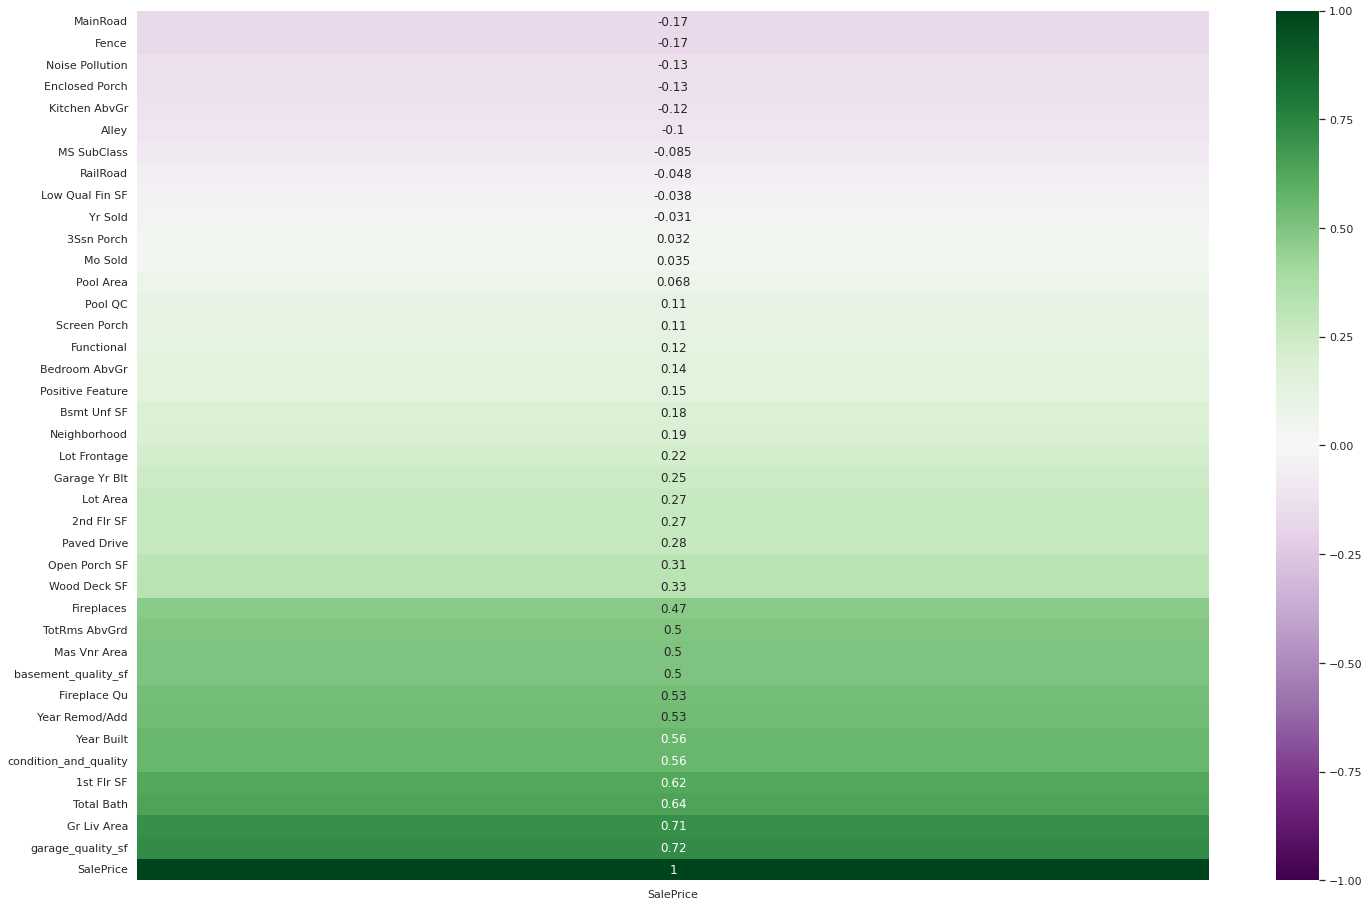

In [60]:
X['SalePrice']=ames_data['SalePrice']
correlations = X.corr()[['SalePrice']].sort_values('SalePrice')
sns.heatmap(correlations,annot = True, vmin = -1, vmax = 1,cmap='PRGn')
X.drop(columns=['SalePrice'],inplace=True)

In [61]:
from sklearn.preprocessing import OrdinalEncoder
object_cols = X.select_dtypes(include='object').columns.to_list()
ordinal_encoder = OrdinalEncoder()
scaler = MinMaxScaler(feature_range=(0, 1))
for col in X.columns:
    if col in object_cols:
        X[col] = ordinal_encoder.fit_transform(X[[col]])
    else:
        #import pdb;pdb.set_trace()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))
X

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,Bsmt Unf SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Mo Sold,Yr Sold,Sale Type,Sale Condition,Total Bath,basement_quality_sf,garage_quality_sf,condition_and_quality,Noise Pollution,RailRoad,MainRoad,Positive Feature
0,0.000000,5.0,0.092834,0.142420,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.637681,0.166667,3.0,1.0,3.0,10.0,4.0,0.07000,3.0,4.0,1.0,5.0,3.0,2.0,0.188784,1.0,1.0,1.0,4.0,0.277673,0.000000,0.0,0.249058,0.375,0.333333,4.0,0.384615,1.0,0.50,0.833333,1.0,0.888083,0.5,0.147472,0.083558,0.0,0.0,0.000000,0.0,0.0,0.0,0.363636,1.0,9.0,4.0,0.166667,0.075478,0.205714,0.325843,0.0,0.0,0.0,0.0
1,0.000000,4.0,0.048856,0.048246,1.0,0.0,3.0,3.0,0.0,4.0,0.0,0.571429,0.0,2.0,0.644928,0.183333,1.0,1.0,13.0,14.0,3.0,0.00000,3.0,4.0,1.0,5.0,5.0,4.0,0.115582,1.0,4.0,1.0,4.0,0.118042,0.000000,0.0,0.105878,0.250,0.333333,4.0,0.230769,1.0,0.00,0.000000,1.0,0.888536,1.0,0.098315,0.000000,0.0,0.0,0.208333,0.0,0.0,0.8,0.454545,1.0,9.0,4.0,0.000000,0.049965,0.094805,0.325843,0.0,0.0,0.5,0.0
2,0.000000,5.0,0.049577,0.060609,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.623188,0.133333,3.0,1.0,14.0,15.0,1.0,0.06750,3.0,4.0,1.0,5.0,5.0,4.0,0.173801,1.0,4.0,1.0,4.0,0.208990,0.000000,0.0,0.187453,0.375,0.333333,2.0,0.307692,1.0,0.00,0.000000,1.0,0.887177,1.0,0.275983,0.048518,0.0,0.0,0.000000,0.0,0.0,0.0,0.454545,1.0,9.0,4.0,0.083333,0.136280,0.040519,0.393258,0.0,0.0,0.0,0.0
3,0.000000,5.0,0.058228,0.046087,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.695652,0.300000,3.0,1.0,3.0,3.0,3.0,0.00000,2.0,4.0,1.0,5.0,5.0,4.0,0.447346,1.0,0.0,1.0,4.0,0.373031,0.000000,0.0,0.334589,0.375,0.333333,0.0,0.461538,1.0,0.50,0.666667,1.0,0.891708,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.272727,1.0,9.0,4.0,0.416667,0.157247,0.203377,0.382022,0.0,0.0,0.0,0.0
4,0.235294,5.0,0.044530,0.058566,1.0,0.0,0.0,3.0,0.0,4.0,0.0,0.321429,0.0,5.0,0.905797,0.800000,1.0,1.0,13.0,14.0,3.0,0.00000,3.0,4.0,2.0,3.0,5.0,4.0,0.058647,1.0,2.0,1.0,4.0,0.124764,0.339467,0.0,0.243971,0.375,0.333333,4.0,0.307692,1.0,0.25,0.666667,1.0,0.904848,1.0,0.148876,0.045822,0.0,0.0,0.000000,0.0,0.0,0.8,0.181818,1.0,9.0,4.0,0.250000,0.140149,0.187792,0.269663,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.352941,5.0,0.017855,0.031022,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.535714,0.0,7.0,0.811594,0.566667,1.0,1.0,6.0,6.0,3.0,0.00000,3.0,4.0,1.0,5.0,5.0,1.0,0.078767,1.0,4.0,1.0,4.0,0.140517,0.000000,0.0,0.126036,0.375,0.333333,4.0,0.307692,1.0,0.00,0.000000,5.0,0.898958,1.0,0.084270,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.181818,0.0,9.0,4.0,0.166667,0.145110,0.076364,0.393258,0.0,0.0,0.0,0.0
2926,0.000000,5.0,0.042303,0.035453,1.0,0.0,0.0,2.0,0.0,4.0,1.0,0.535714,0.0,2.0,0.804348,0.550000,1.0,1.0,6.0,6.0,3.0,0.00000,3.0,4.0,1.0,3.0,5.0,1.0,0.102312,1.0,4.0,1.0,4.0,0.119303,0.000000,0.0,0.107008,0.250,0.333333,4.0,0.230769,1.0,0.00,0.000000,1.0,0.898505,1.0,0.115169,0.000000,0.0,0.0,0.000000,0.0,0.0,0.8,0.454545,0.0,9.0,4.0,0.166667,0.083392,0.062857,0.269663,0.0,0.0,0.0,0.0
2927,0.382353,5.0,0.035879,0.042726,1.0,0.0,3.0,3.0,0.0,4.0,0.0,0.535714,0.0,6.0,0.869565,0.700000,1.0,1.0,6.0,16.0,3.0,0.00000,3.0,4.0,2.0,3.0,5.0,1.0,0.246147,1.0,4.0,1.0,4.0,0.133585,0.000000,0.0,0.119819

In [62]:
X

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,Bsmt Unf SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Mo Sold,Yr Sold,Sale Type,Sale Condition,Total Bath,basement_quality_sf,garage_quality_sf,condition_and_quality,Noise Pollution,RailRoad,MainRoad,Positive Feature
0,0.000000,5.0,0.092834,0.142420,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.637681,0.166667,3.0,1.0,3.0,10.0,4.0,0.07000,3.0,4.0,1.0,5.0,3.0,2.0,0.188784,1.0,1.0,1.0,4.0,0.277673,0.000000,0.0,0.249058,0.375,0.333333,4.0,0.384615,1.0,0.50,0.833333,1.0,0.888083,0.5,0.147472,0.083558,0.0,0.0,0.000000,0.0,0.0,0.0,0.363636,1.0,9.0,4.0,0.166667,0.075478,0.205714,0.325843,0.0,0.0,0.0,0.0
1,0.000000,4.0,0.048856,0.048246,1.0,0.0,3.0,3.0,0.0,4.0,0.0,0.571429,0.0,2.0,0.644928,0.183333,1.0,1.0,13.0,14.0,3.0,0.00000,3.0,4.0,1.0,5.0,5.0,4.0,0.115582,1.0,4.0,1.0,4.0,0.118042,0.000000,0.0,0.105878,0.250,0.333333,4.0,0.230769,1.0,0.00,0.000000,1.0,0.888536,1.0,0.098315,0.000000,0.0,0.0,0.208333,0.0,0.0,0.8,0.454545,1.0,9.0,4.0,0.000000,0.049965,0.094805,0.325843,0.0,0.0,0.5,0.0
2,0.000000,5.0,0.049577,0.060609,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.623188,0.133333,3.0,1.0,14.0,15.0,1.0,0.06750,3.0,4.0,1.0,5.0,5.0,4.0,0.173801,1.0,4.0,1.0,4.0,0.208990,0.000000,0.0,0.187453,0.375,0.333333,2.0,0.307692,1.0,0.00,0.000000,1.0,0.887177,1.0,0.275983,0.048518,0.0,0.0,0.000000,0.0,0.0,0.0,0.454545,1.0,9.0,4.0,0.083333,0.136280,0.040519,0.393258,0.0,0.0,0.0,0.0
3,0.000000,5.0,0.058228,0.046087,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.571429,0.0,2.0,0.695652,0.300000,3.0,1.0,3.0,3.0,3.0,0.00000,2.0,4.0,1.0,5.0,5.0,4.0,0.447346,1.0,0.0,1.0,4.0,0.373031,0.000000,0.0,0.334589,0.375,0.333333,0.0,0.461538,1.0,0.50,0.666667,1.0,0.891708,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.272727,1.0,9.0,4.0,0.416667,0.157247,0.203377,0.382022,0.0,0.0,0.0,0.0
4,0.235294,5.0,0.044530,0.058566,1.0,0.0,0.0,3.0,0.0,4.0,0.0,0.321429,0.0,5.0,0.905797,0.800000,1.0,1.0,13.0,14.0,3.0,0.00000,3.0,4.0,2.0,3.0,5.0,4.0,0.058647,1.0,2.0,1.0,4.0,0.124764,0.339467,0.0,0.243971,0.375,0.333333,4.0,0.307692,1.0,0.25,0.666667,1.0,0.904848,1.0,0.148876,0.045822,0.0,0.0,0.000000,0.0,0.0,0.8,0.181818,1.0,9.0,4.0,0.250000,0.140149,0.187792,0.269663,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.352941,5.0,0.017855,0.031022,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.535714,0.0,7.0,0.811594,0.566667,1.0,1.0,6.0,6.0,3.0,0.00000,3.0,4.0,1.0,5.0,5.0,1.0,0.078767,1.0,4.0,1.0,4.0,0.140517,0.000000,0.0,0.126036,0.375,0.333333,4.0,0.307692,1.0,0.00,0.000000,5.0,0.898958,1.0,0.084270,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.181818,0.0,9.0,4.0,0.166667,0.145110,0.076364,0.393258,0.0,0.0,0.0,0.0
2926,0.000000,5.0,0.042303,0.035453,1.0,0.0,0.0,2.0,0.0,4.0,1.0,0.535714,0.0,2.0,0.804348,0.550000,1.0,1.0,6.0,6.0,3.0,0.00000,3.0,4.0,1.0,3.0,5.0,1.0,0.102312,1.0,4.0,1.0,4.0,0.119303,0.000000,0.0,0.107008,0.250,0.333333,4.0,0.230769,1.0,0.00,0.000000,1.0,0.898505,1.0,0.115169,0.000000,0.0,0.0,0.000000,0.0,0.0,0.8,0.454545,0.0,9.0,4.0,0.166667,0.083392,0.062857,0.269663,0.0,0.0,0.0,0.0
2927,0.382353,5.0,0.035879,0.042726,1.0,0.0,3.0,3.0,0.0,4.0,0.0,0.535714,0.0,6.0,0.869565,0.700000,1.0,1.0,6.0,16.0,3.0,0.00000,3.0,4.0,2.0,3.0,5.0,1.0,0.246147,1.0,4.0,1.0,4.0,0.133585,0.000000,0.0,0.119819

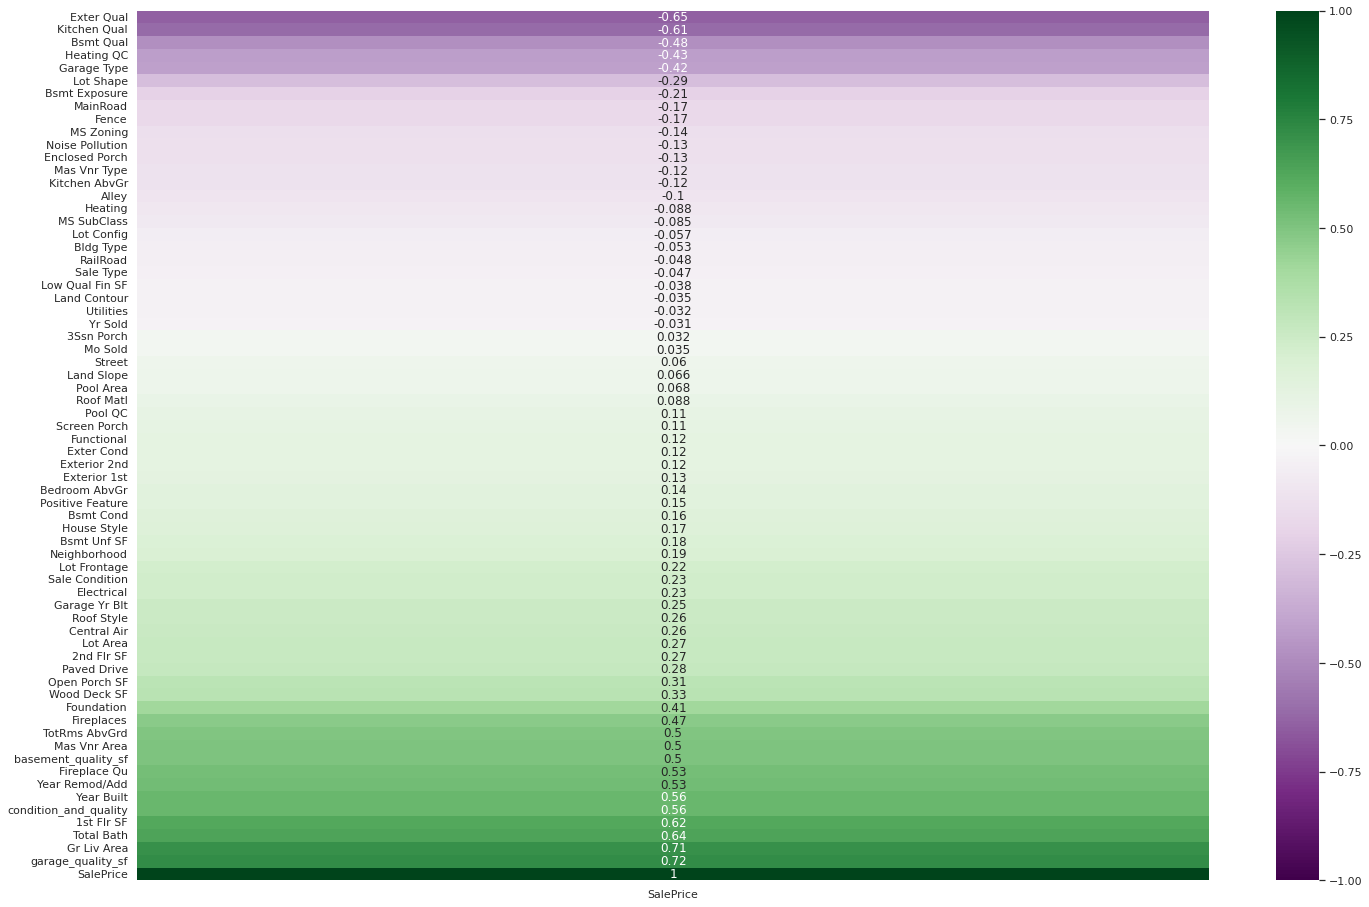

In [63]:
X['SalePrice']=ames_data['SalePrice']
correlations = X.corr()[['SalePrice']].sort_values('SalePrice')
sns.heatmap(correlations,annot = True, vmin = -1, vmax = 1,cmap='PRGn')
X.drop(columns=['SalePrice'],inplace=True)

dt_reg: 0.638401 (0.024183)
knn_reg: 0.659686 (0.047803)
lin_reg: 0.842788 (0.066590)
xgb_reg: 0.911857 (0.009446)
rid_reg: 0.844387 (0.062316)
las_reg: 0.842781 (0.066521)


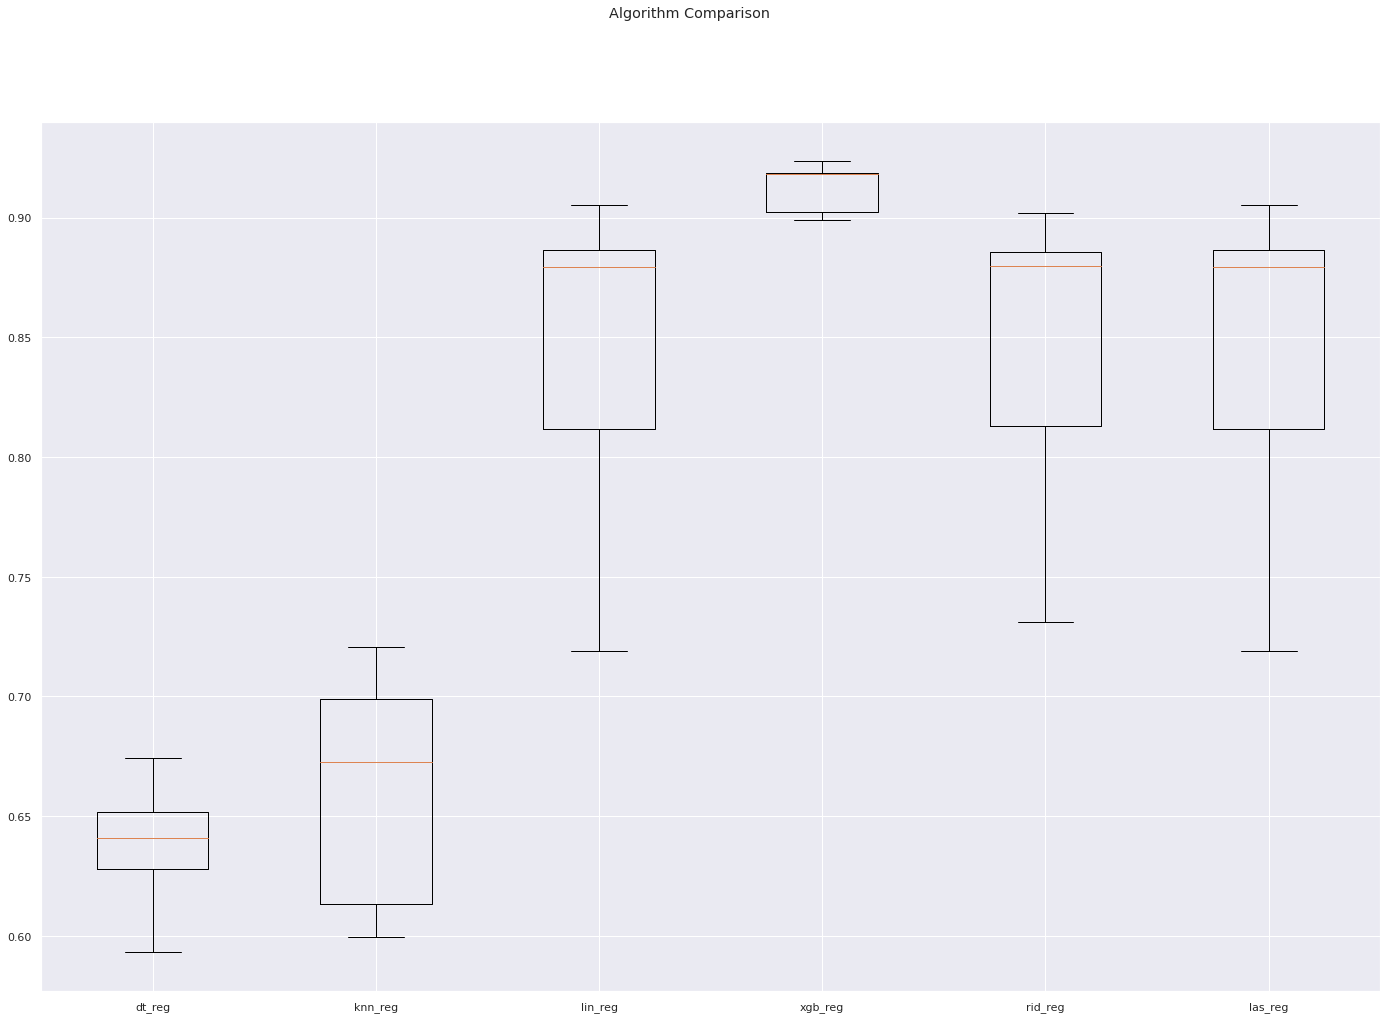

In [64]:
## model params
max_depth_val = 3
alpha_val = 0.5
K = 3
## initialize all models
models = []
models.append(('dt_reg', DecisionTreeRegressor(max_depth=max_depth_val)))
models.append(('knn_reg', KNeighborsRegressor(n_neighbors=K)))
models.append(('lin_reg', make_pipeline(StandardScaler(with_mean=False), LinearRegression())))
models.append(('xgb_reg', GradientBoostingRegressor(max_features='sqrt',max_depth=max_depth_val)))
models.append(('rid_reg', Ridge(alpha=alpha_val)))
models.append(('las_reg', Lasso(alpha=alpha_val)))

# test models
# test models
results = []
names = []
scoring = 'explained_variance'
#scoring = 'neg_mean_squared_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=7,shuffle=True ,random_state=42)
    #import pdb;pdb.set_trace()
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

       

In [ ]:
#knn_root_mean_squared_error = []
#linear_regression_root_mean_squared_error = []
#xgb_regression_root_mean_squared_error = []
#lasso_regression_root_mean_squared_error = []
#ridge_regression_root_mean_squared_error = []
#decision_tree_root_mean_squared_error = []
##best_svr = SVR(kernel='rbf')
#cv = KFold(n_splits=7, random_state=42, shuffle=True)
##ames_feature_names = X.columns.to_list()
##ames_feature_names=['Pool QC', 'Garage Cond', 'Lot Area', '2nd Flr SF', 'Bsmt Full Bath', 'Paved Drive','Garage Qual', 'Half Bath', 'BsmtFin Type 1', 'BsmtFin SF 1', 'Fireplaces', 'TotRms AbvGrd','Fireplace Qu', 'Garage Finish','Full Bath', '1st Flr SF', 'Total Bsmt SF','Garage Cars', 'Gr Liv Area', 'Overall Qual','Neighborhood']
##ames_feature_names=['Pool Area', 'Pool QC', 'Screen Porch', 'Bedroom AbvGr','Bsmt Unf SF', 'Lot Frontage', 'Garage Yr Blt', 'Garage Cond', 'Lot Area', '2nd Flr SF', 'Bsmt Full Bath', 'Paved Drive','Garage Qual', 'Half Bath', 'Open Porch SF', 'Wood Deck SF','BsmtFin Type 1', 'BsmtFin SF 1', 'Fireplaces', 'TotRms AbvGrd','Mas Vnr Area', 'Fireplace Qu', 'Year Remod/Add', 'Garage Finish','Full Bath', 'Year Built', '1st Flr SF', 'Total Bsmt SF', 'Garage Area','Garage Cars', 'Gr Liv Area', 'Overall Qual','Neighborhood']
#for train_index, test_index in cv.split(X):
#    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
#    
#    ## Decision Tree Regression
#    # Fit regression model
#    for depth in np.arange(1,9):
#        dt_reg = DecisionTreeRegressor(max_depth=depth)
#        dt_model = dt_reg.fit(X_train, y_train)
#        # Predict
#        pred = dt_reg.predict(X_test)
#        error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#        decision_tree_root_mean_squared_error.append([error,depth]) #store rmse values
#        print('Decision Tree RMSE value for depth= ' , depth , 'is:', error)
#        #fig = plt.figure(figsize=(25,20))
#        #_ = tree.plot_tree(dt_reg, feature_names=ames_feature_names, filled=True)
#
#    
#    ## K-Nearest-Neighbors Regression
#    for K in np.arange(1,19,2):
#        neigh = KNeighborsRegressor(n_neighbors=K)
#        #print("Train Index: ", train_index, "\n")
#        #print("Test Index: ", test_index)
#        neigh.fit(X_train, y_train)  #fit the model
#        pred=neigh.predict(X_test)   #make prediction on test set
#        error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#        knn_root_mean_squared_error.append([error,K]) #store rmse values
#        print('KNN RMSE value for k= ' , K , 'is:', error)
#        #best_svr.fit(X_train, y_train)
#        #scores.append(best_svr.score(X_test, y_test)
#    
#    ## Linear Regression   
#    lr = LinearRegression(normalize=True)
#    lr.fit(X_train, y_train)
#    pred = lr.predict(X_test)
#    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#    linear_regression_root_mean_squared_error.append(error) #store rmse values
#    print('Linear Reg RMSE value is', error)
#    
#    
#
#    ## Extreme Gradient Booosting Regression
#    for depth in np.arange(1,9):
#        xgb_reg = GradientBoostingRegressor(random_state=42,max_features='sqrt',max_depth=depth)
#        xgb_reg.fit(X_train, y_train)
#        pred = xgb_reg.predict(X_test)
#        xgb_reg.score(X_test, y_test)
#        xgb_feature_exploration = pd.DataFrame()
#        xgb_feature_exploration['Feature']=ames_feature_names
#        xgb_feature_exploration['Importance']=xgb_reg.feature_importances_
#        error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#        xgb_regression_root_mean_squared_error.append([error,depth]) #store rmse values
#        print('XGB RMSE value for depth' , depth , 'is:', error)
#        #xgb_feature_exploration
#
#    for alpha_val in np.arange(1,20):
#        ridge_reg = Ridge(alpha=alpha_val)
#        ridge_reg.fit(X_train, y_train)
#        pred=ridge_reg.predict(X_test)   #make prediction on test set
#        error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#        ridge_regression_root_mean_squared_error.append([error,alpha_val]) #store rmse values
#        print('Ridge RMSE value for alpha=' , alpha_val , ' is:', error)
#        
#        lasso_reg = Lasso(alpha=alpha_val)
#        lasso_reg.fit(X_train, y_train)
#        pred=lasso_reg.predict(X_test)   #make prediction on test set
#        error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#        lasso_regression_root_mean_squared_error.append([error,alpha_val]) #store rmse values
#        print('Lasso RMSE value for alpha=' , alpha_val , ' is:', error) 

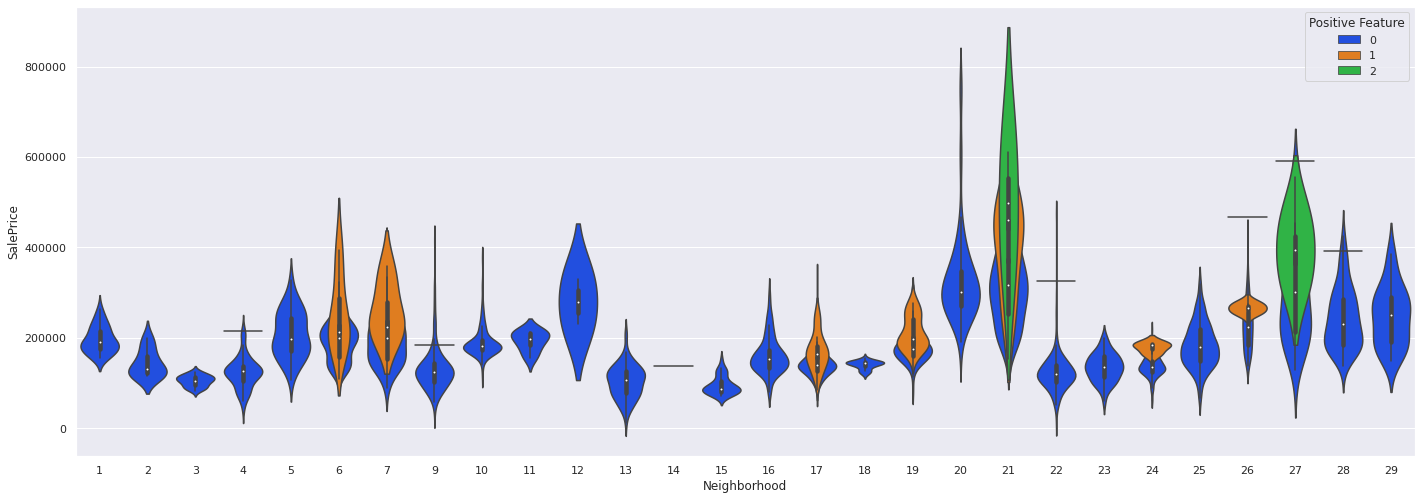

In [65]:
sns.light_palette("seagreen", as_cmap=True)
sns.violinplot(x='Neighborhood', y='SalePrice', kind="swarm",hue='Positive Feature',palette='bright' , dodge=False,data=ames_data)

plt.gcf().set_size_inches(24, 8.27)

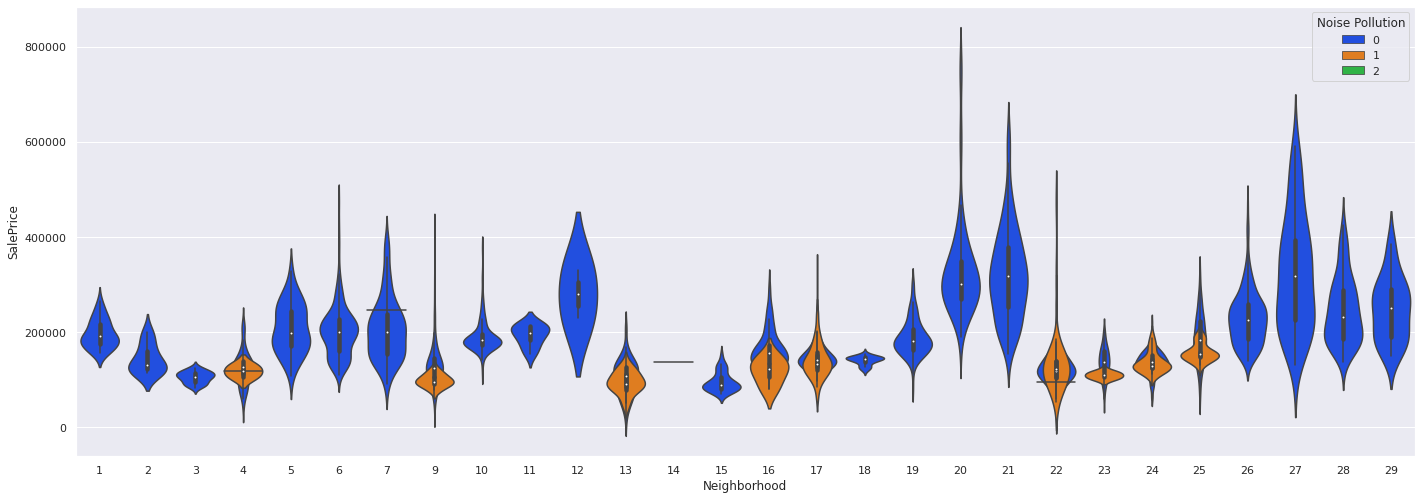

In [66]:
sns.light_palette("seagreen", as_cmap=True)
sns.violinplot(x='Neighborhood', y='SalePrice', kind="swarm",hue='Noise Pollution',palette='bright' , dodge=False,data=ames_data)

plt.gcf().set_size_inches(24, 8.27)

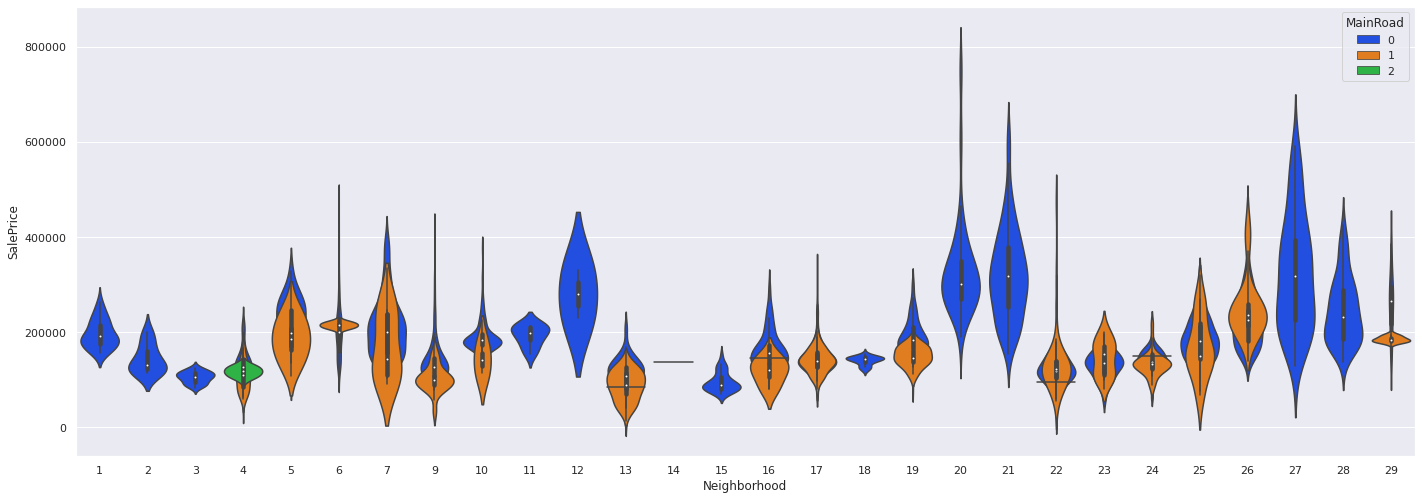

In [67]:
sns.light_palette("seagreen", as_cmap=True)
sns.violinplot(x='Neighborhood', y='SalePrice', kind="swarm",hue='MainRoad',palette='bright' , dodge=False,data=ames_data)

plt.gcf().set_size_inches(24, 8.27)

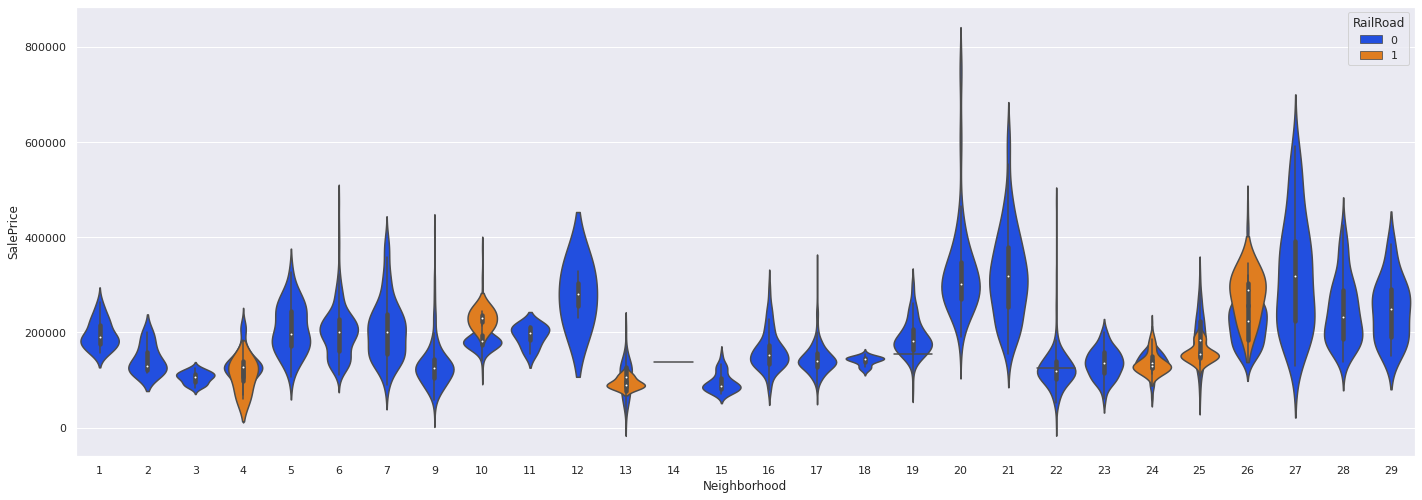

In [68]:
sns.light_palette("seagreen", as_cmap=True)
sns.violinplot(x='Neighborhood', y='SalePrice', kind="swarm",hue='RailRoad',palette='bright' , dodge=False,data=ames_data)

plt.gcf().set_size_inches(24, 8.27)

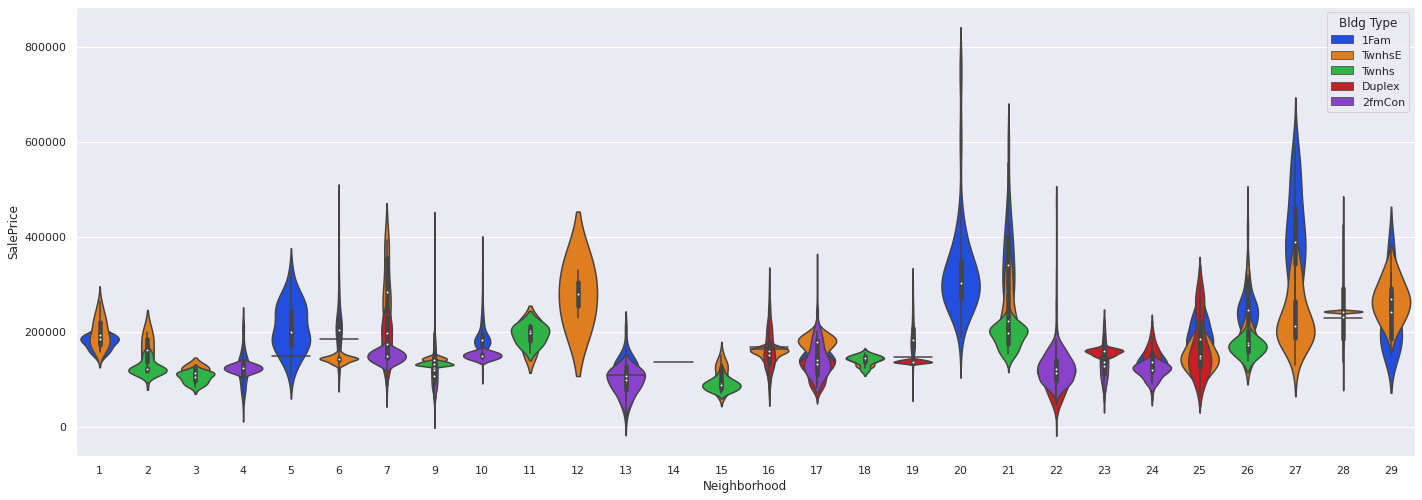

In [69]:
sns.light_palette("seagreen", as_cmap=True)
sns.violinplot(x='Neighborhood', y='SalePrice', kind="swarm",hue='Bldg Type',palette='bright' , dodge=False,data=ames_data)

plt.gcf().set_size_inches(24, 8.27)

In [71]:
TopFeatures = xgb_feature_exploration.loc[xgb_feature_exploration['Importance']>=0.01]

NameError: name 'xgb_feature_exploration' is not defined

In [32]:
sns.stripplot(x="Feature", y="Importance", data=TopFeatures)
plt.gcf().set_size_inches(50, 8.27)

NameError: name 'TopFeatures' is not defined

In [33]:
ames_data.loc[test_index,'Yr Sold']

NameError: name 'test_index' is not defined

In [ ]:
    xgb_reg = GradientBoostingRegressor(random_state=42,max_features='sqrt',max_depth=3)
    xgb_reg.fit(X_train, y_train)
    pred = xgb_reg.predict(X_test)
    xgb_reg.score(X_test, y_test)
    xgb_feature_exploration = pd.DataFrame()
    xgb_feature_exploration['Feature']=ames_feature_names
    xgb_feature_exploration['Importance']=xgb_reg.feature_importances_
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    xgb_regression_root_mean_squared_error.append([error,depth]) #store rmse values
    print('XGB RMSE value for depth' , depth , 'is:', error)
    #xgb_feature_exploration


In [ ]:
sns.scatterplot(x=y_test,y=pred,hue=ames_data.loc[test_index,'Neighborhood'],palette="deep")

In [45]:
## Linear Regression   
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
#linear_regression_root_mean_squared_error.append(error) #store rmse values
#print('Linear Reg RMSE value is', error)
error
blah = lr.coef_
lin_reg_df = pd.DataFrame()
lin_reg_df['Cols'] = X.columns
lin_reg_df['value']= blah
lin_reg_df.sort_values(by='value')

,Cols,value
34,1st Flr SF,-1.451777e+18
35,2nd Flr SF,-6.296829e+17
36,Low Qual Fin SF,-3.244468e+17
53,Pool Area,-1.088772e+05
3,Lot Frontage,-6.560409e+04
...,...,...
4,Lot Area,8.638202e+04
54,Pool QC,8.860007e+04
63,condition_and_quality,1.220622e+05
61,basement_quality_sf,1.599625e+05


In [46]:
lin_reg_df.loc[lin_reg_df['value']<=1e-15]

,Cols,value
0,Order,-4.624752e+04
1,MS SubClass,-1.347011e+04
2,MS Zoning,-4.785628e+02
3,Lot Frontage,-6.560409e+04
6,Alley,-5.626811e+03
7,Lot Shape,-7.899574e+02
10,Lot Config,-2.197158e+02
13,Bldg Type,-2.560603e+03
14,House Style,-1.591598e+03
19,Exterior 1st,-7.147234e+02


In [ ]:
sns.scatterplot(x=y_test,y=pred,hue=ames_data.loc[test_index,'Neighborhood'],palette="deep")

In [ ]:
    
    ## K-Nearest-Neighbors Regression
    #for K in np.arange(1,19,2):
    neigh = KNeighborsRegressor(n_neighbors=3)
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)
    neigh.fit(X_train, y_train)  #fit the model
    pred=neigh.predict(X_test)   #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    knn_root_mean_squared_error.append([error,K]) #store rmse values
    #print('KNN RMSE value for k= ' , K , 'is:', error)
    #best_svr.fit(X_train, y_train)
    #scores.append(best_svr.score(X_test, y_test)
    

In [ ]:
sns.scatterplot(x=y_test,y=pred,hue=ames_data.loc[test_index,'Neighborhood'],palette="deep")

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X, y)
pred=ridge_reg.predict(X_test)   #make prediction on test set
error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse

In [30]:
cv = KFold(n_splits=7, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    xgb_reg = GradientBoostingRegressor(random_state=42,max_features='sqrt',max_depth=3)
    xgb_reg.fit(X_train, y_train)
    pred = xgb_reg.predict(X_test)
    xgb_reg.score(X_test, y_test)
    #xgb_feature_exploration = pd.DataFrame()
    #xgb_feature_exploration['Feature']=ames_feature_names
    #xgb_feature_exploration['Importance']=xgb_reg.feature_importances_
    #error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    #xgb_regression_root_mean_squared_error.append([error,depth]) #store rmse values
    #print('XGB RMSE value for depth' , depth , 'is:', error)
    #xgb_feature_exploration

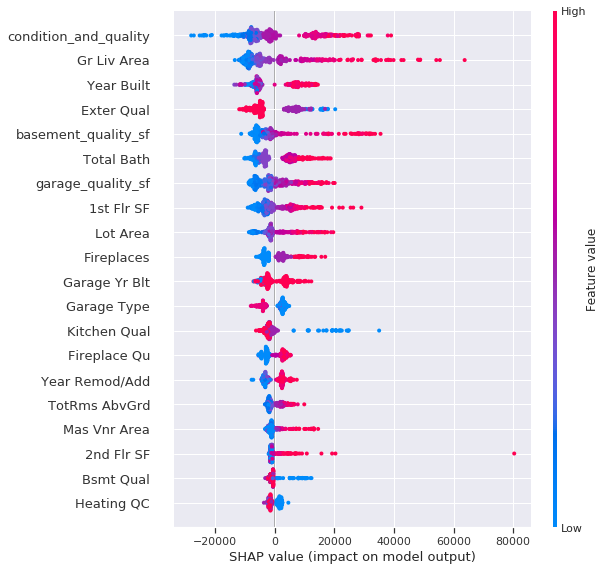

In [34]:
import shap
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

